In [ ]:
# TODO: colocar tqdm 
# TODO: ver caminhos de salvamento das imagens e modelos (precisam de pasta própria para cada run)
# TODO: ver alguma forma de visualizar o espaço latente (PCA, t-SNE, UMAP), distribuições normal e gerada e os perfis gerados nesse espaço

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

# Find the project root (the nearest ancestor that contains `src`) and add it to sys.path
cwd = Path.cwd()
project_root = cwd
for _ in range(6):
    if (project_root / "src").exists():
        break
    if project_root.parent == project_root:
        break
    project_root = project_root.parent
else:
    project_root = cwd

proj_path = str(project_root.resolve())
if proj_path not in sys.path:
    # Insert at front so local packages take precedence
    sys.path.insert(0, proj_path)

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.vae import CSTVariationalAutoencoder
from src.utils import generate_and_plot_airfoils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# --- Hyperparameters ---
EPOCHS = 1000
BATCH_SIZE = 64
LATENT_DIM = 128
NPV = 12 # Number of CST coefficients MUST BE EQUAL TO THE ONE USED IN DATASET GENERATION
LEARNING_RATE = 1e-4

In [11]:
# --- Dataset Loading ---
dataset_path = Path(proj_path) / "data" / "processed" / "kulfan_dataset_75.json"

print("Loading dataset...")
airfoil_dataset = pd.read_json(dataset_path)
display(airfoil_dataset)

# Prepare the data: concatenate lower and upper weights along with TE thickness and leading edge weight
airfoil_data = airfoil_dataset["kulfan_parameters"].apply(
  lambda p: np.concatenate([
    p["lower_weights"], 
    p["upper_weights"], 
    [p["TE_thickness"]], 
    [p["leading_edge_weight"]]
    ], axis=0)).to_list()

# airfoil_data = np.random.rand(1000, NPV * 2).astype(np.float32) 

# Create a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(airfoil_data)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
print(f"Dataset loaded: {len(airfoil_data)} samples")


Loading dataset...


,airfoil_name,coordinates,kulfan_parameters,shape,points
0,2032c,"[[1.0, 0.0016], [0.9995417967, 0.0016995265], ...","{'lower_weights': [-0.10683679110000001, -0.14...","[149, 2]",149
1,AV-1.7-8,"[[0.9999998992, 8.999540000000001e-05], [0.999...","{'lower_weights': [-0.1152837456, -0.227979137...","[149, 2]",149
2,BE5030FVNC2t,"[[0.9999989486, 0.0019689325000000002], [0.999...","{'lower_weights': [-0.0610602988, 0.0638932556...","[149, 2]",149
3,BE5045FVNC2t,"[[0.999999238, 0.001931519], [0.9995510637, 0....","{'lower_weights': [-0.0359906949, 0.2252238068...","[149, 2]",149
4,BE5655FVNC2t,"[[0.9999990278, 0.0021509264], [0.9995559253, ...","{'lower_weights': [-0.0347854667, 0.2633330728...","[149, 2]",149
...,...,...,...,...,...
2165,ys900,"[[1.0, 0.0], [0.9995461495000001, 1.53112e-05]...","{'lower_weights': [-0.047151649100000005, -0.1...","[149, 2]",149
2166,ys915,"[[1.0, -2.082292484e-22], [0.9995457502, 4.159...","{'lower_weights': [-0.0760449584, -0.189496793...","[149, 2]",149
2167,ys920,"[[1.0, -7.676703493e-20], [0.9995469423000001,...","{'lower_weights': [-0.1055076258, -0.293632588...","[149, 2]",149
2168,ys930,"[[1.0, 2.31071436e-21], [0.9995470971, 7.2366e...","{'lower_weights': [-0.0741614235, -0.082281227...","[149, 2]",149


Dataset loaded: 2170 samples


In [32]:
# --- Instantiate Model, Optimizer, and Loss ---
vae = CSTVariationalAutoencoder(npv=NPV, latent_dim=LATENT_DIM)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Main Loss (Reconstruction Loss)
reconstruction_loss = tf.keras.losses.MeanSquaredError()

# --- Training Step (for one batch) ---
@tf.function
def train_step(x_batch):
    # Open a GradientTape to record operations
    with tf.GradientTape() as tape:
        # Run the forward pass
        _, reco_weights, reco_params = vae(x_batch, training=True)
        reco_weights_flat = tf.reshape(reco_weights, [tf.shape(reco_weights)[0], -1])
        reconstructed_batch = tf.concat([reco_weights_flat, reco_params], axis=1)
        
        # Calculate Main Loss (Reconstruction)
        reco_loss = reconstruction_loss(x_batch, reconstructed_batch)

        # Get KL Loss (added by self.add_loss() inside the model)
        kl_loss = sum(vae.losses)
        
        # Calculate Total Loss
        total_loss = reco_loss + kl_loss
        
    # Calculate Gradients
    gradients = tape.gradient(total_loss, vae.trainable_variables)
    
    # Apply Gradients to update weights
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    
    # Return the losses for logging
    return total_loss, reco_loss, kl_loss


Starting training...


Epoch 1/1000: 100%|██████████| 34/34 [00:00<00:00, 37.71it/s]


Generating and plotting airfoils...


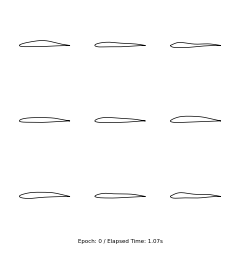

Epoch 2/1000: 100%|██████████| 34/34 [00:00<00:00, 45.61it/s]


Generating and plotting airfoils...


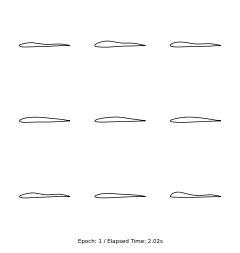

Epoch 3/1000: 100%|██████████| 34/34 [00:00<00:00, 37.19it/s]


Generating and plotting airfoils...


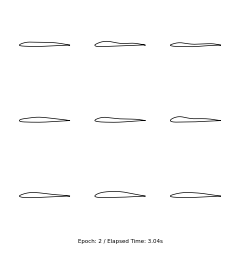

Epoch 4/1000: 100%|██████████| 34/34 [00:00<00:00, 40.16it/s]


Generating and plotting airfoils...


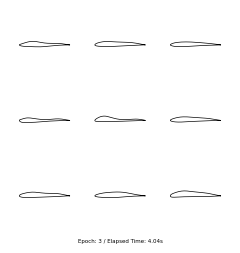

Epoch 5/1000: 100%|██████████| 34/34 [00:00<00:00, 46.95it/s]


Generating and plotting airfoils...


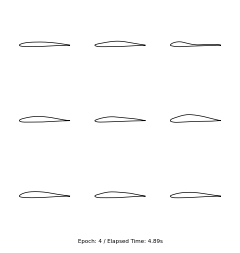

--- Saving model checkpoint for epoch 5 ---


Epoch 6/1000: 100%|██████████| 34/34 [00:00<00:00, 49.71it/s]


Generating and plotting airfoils...


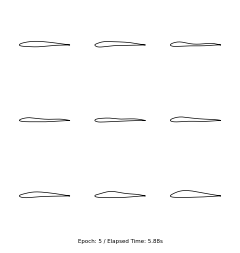

Epoch 7/1000: 100%|██████████| 34/34 [00:00<00:00, 48.41it/s]


Generating and plotting airfoils...


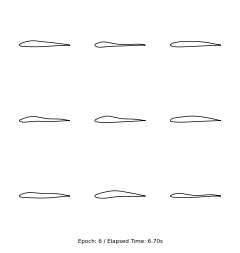

Epoch 8/1000: 100%|██████████| 34/34 [00:00<00:00, 48.92it/s]


Generating and plotting airfoils...


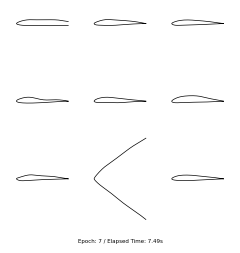

Epoch 9/1000: 100%|██████████| 34/34 [00:00<00:00, 41.78it/s]


Generating and plotting airfoils...


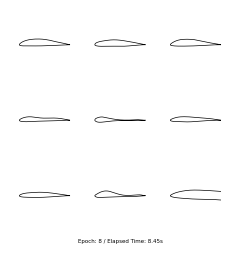

Epoch 10/1000: 100%|██████████| 34/34 [00:00<00:00, 43.02it/s]


Generating and plotting airfoils...


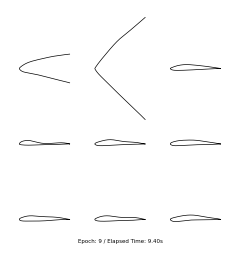

--- Saving model checkpoint for epoch 10 ---


Epoch 11/1000: 100%|██████████| 34/34 [00:00<00:00, 42.83it/s]


Generating and plotting airfoils...


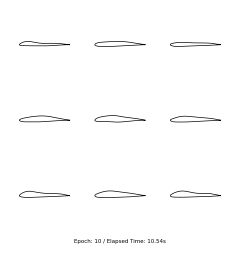

Epoch 12/1000: 100%|██████████| 34/34 [00:00<00:00, 47.98it/s]


Generating and plotting airfoils...


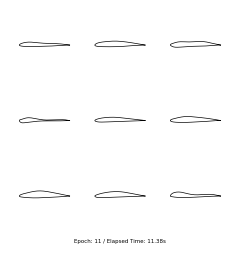

Epoch 13/1000: 100%|██████████| 34/34 [00:00<00:00, 46.62it/s]


Generating and plotting airfoils...


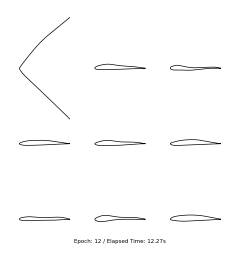

Epoch 14/1000: 100%|██████████| 34/34 [00:00<00:00, 45.38it/s]


Generating and plotting airfoils...


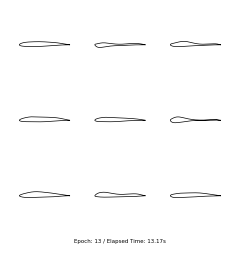

Epoch 15/1000: 100%|██████████| 34/34 [00:00<00:00, 45.33it/s]


Generating and plotting airfoils...


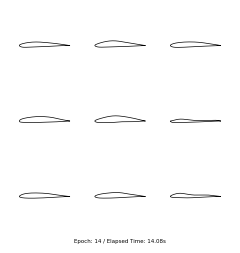

--- Saving model checkpoint for epoch 15 ---


Epoch 16/1000: 100%|██████████| 34/34 [00:00<00:00, 44.75it/s]


Generating and plotting airfoils...


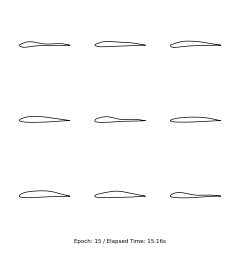

Epoch 17/1000: 100%|██████████| 34/34 [00:00<00:00, 46.24it/s]


Generating and plotting airfoils...


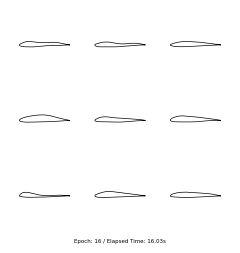

Epoch 18/1000: 100%|██████████| 34/34 [00:00<00:00, 41.74it/s]


Generating and plotting airfoils...


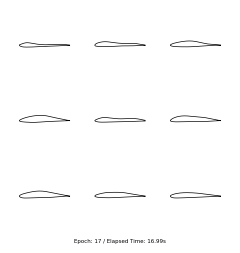

Epoch 19/1000: 100%|██████████| 34/34 [00:00<00:00, 37.40it/s]


Generating and plotting airfoils...


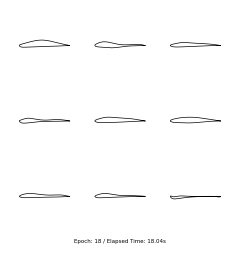

Epoch 20/1000: 100%|██████████| 34/34 [00:00<00:00, 42.39it/s]


Generating and plotting airfoils...


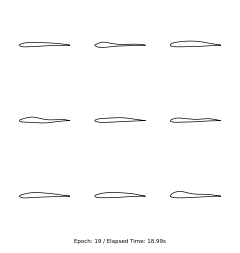

--- Saving model checkpoint for epoch 20 ---


Epoch 21/1000: 100%|██████████| 34/34 [00:00<00:00, 44.47it/s]


Generating and plotting airfoils...


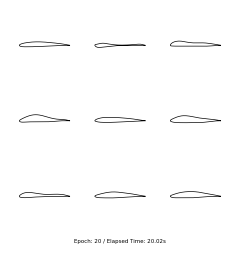

Epoch 22/1000: 100%|██████████| 34/34 [00:00<00:00, 48.00it/s]


Generating and plotting airfoils...


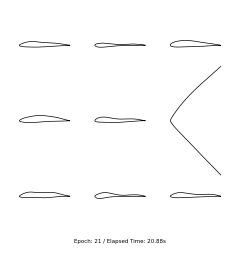

Epoch 23/1000: 100%|██████████| 34/34 [00:00<00:00, 47.90it/s]


Generating and plotting airfoils...


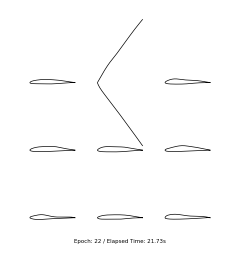

Epoch 24/1000: 100%|██████████| 34/34 [00:00<00:00, 44.79it/s]


Generating and plotting airfoils...


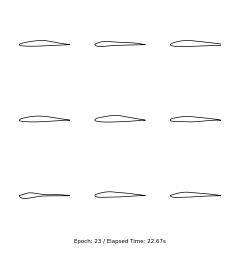

Epoch 25/1000: 100%|██████████| 34/34 [00:00<00:00, 45.41it/s]


Generating and plotting airfoils...


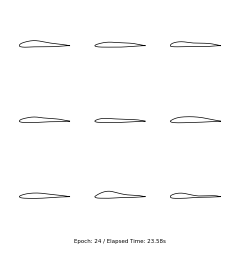

--- Saving model checkpoint for epoch 25 ---


Epoch 26/1000: 100%|██████████| 34/34 [00:00<00:00, 40.12it/s]


Generating and plotting airfoils...


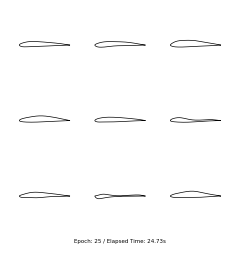

Epoch 27/1000: 100%|██████████| 34/34 [00:00<00:00, 47.31it/s]


Generating and plotting airfoils...


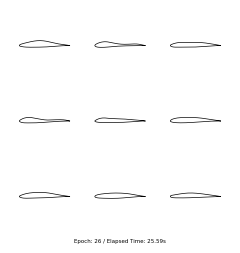

Epoch 28/1000: 100%|██████████| 34/34 [00:00<00:00, 48.05it/s]


Generating and plotting airfoils...


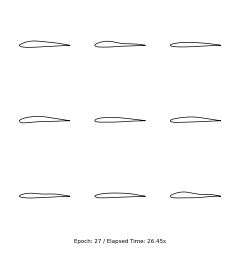

Epoch 29/1000: 100%|██████████| 34/34 [00:00<00:00, 44.90it/s]


Generating and plotting airfoils...


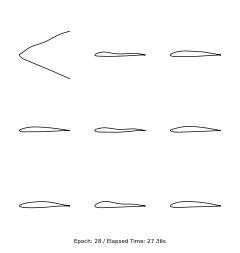

Epoch 30/1000: 100%|██████████| 34/34 [00:00<00:00, 47.72it/s]


Generating and plotting airfoils...


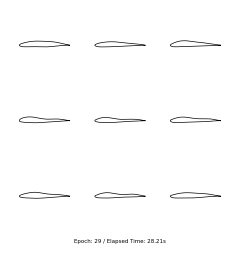

--- Saving model checkpoint for epoch 30 ---


Epoch 31/1000: 100%|██████████| 34/34 [00:00<00:00, 46.79it/s]


Generating and plotting airfoils...


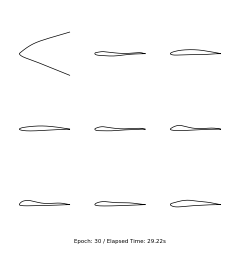

Epoch 32/1000: 100%|██████████| 34/34 [00:00<00:00, 45.20it/s]


Generating and plotting airfoils...


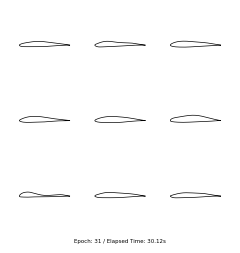

Epoch 33/1000: 100%|██████████| 34/34 [00:00<00:00, 48.28it/s]


Generating and plotting airfoils...


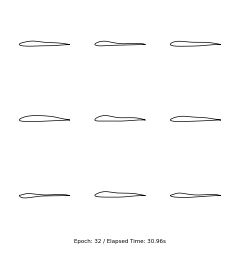

Epoch 34/1000: 100%|██████████| 34/34 [00:00<00:00, 40.02it/s]


Generating and plotting airfoils...


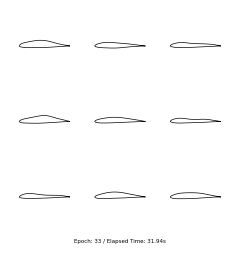

Epoch 35/1000: 100%|██████████| 34/34 [00:00<00:00, 43.74it/s]


Generating and plotting airfoils...


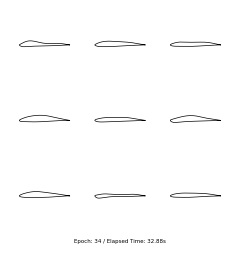

--- Saving model checkpoint for epoch 35 ---


Epoch 36/1000: 100%|██████████| 34/34 [00:00<00:00, 47.96it/s]


Generating and plotting airfoils...


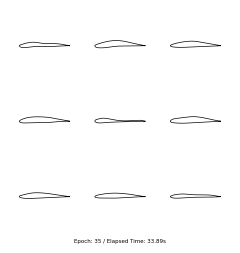

Epoch 37/1000: 100%|██████████| 34/34 [00:00<00:00, 46.46it/s]


Generating and plotting airfoils...


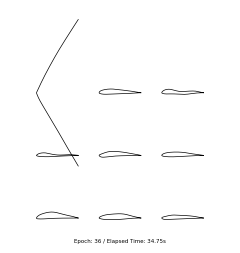

Epoch 38/1000: 100%|██████████| 34/34 [00:00<00:00, 45.10it/s]


Generating and plotting airfoils...


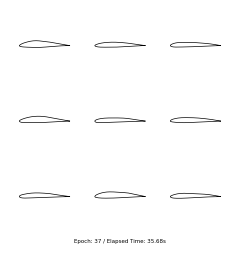

Epoch 39/1000: 100%|██████████| 34/34 [00:00<00:00, 47.44it/s]


Generating and plotting airfoils...


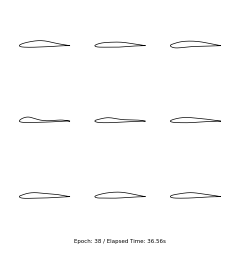

Epoch 40/1000: 100%|██████████| 34/34 [00:00<00:00, 45.93it/s]


Generating and plotting airfoils...


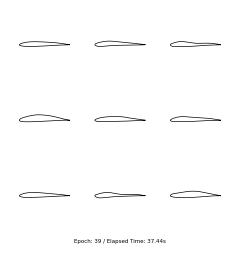

--- Saving model checkpoint for epoch 40 ---


Epoch 41/1000: 100%|██████████| 34/34 [00:00<00:00, 44.68it/s]


Generating and plotting airfoils...


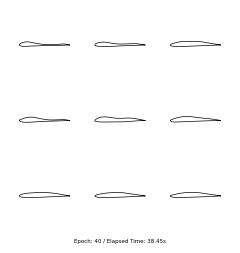

Epoch 42/1000: 100%|██████████| 34/34 [00:00<00:00, 40.32it/s]


Generating and plotting airfoils...


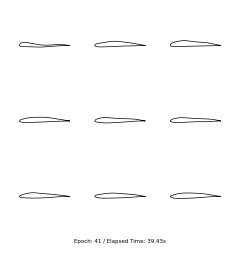

Epoch 43/1000: 100%|██████████| 34/34 [00:00<00:00, 44.52it/s]


Generating and plotting airfoils...


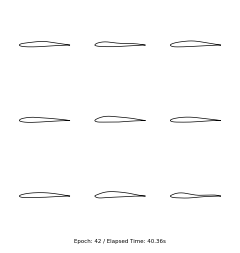

Epoch 44/1000: 100%|██████████| 34/34 [00:00<00:00, 43.89it/s]


Generating and plotting airfoils...


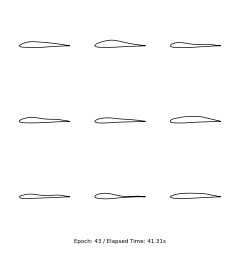

Epoch 45/1000: 100%|██████████| 34/34 [00:00<00:00, 43.42it/s]


Generating and plotting airfoils...


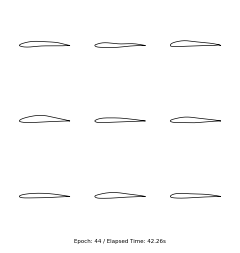

--- Saving model checkpoint for epoch 45 ---


Epoch 46/1000: 100%|██████████| 34/34 [00:00<00:00, 42.48it/s]


Generating and plotting airfoils...


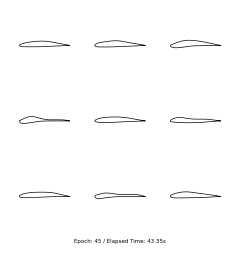

Epoch 47/1000: 100%|██████████| 34/34 [00:00<00:00, 44.21it/s]


Generating and plotting airfoils...


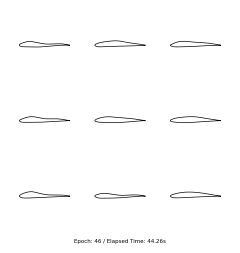

Epoch 48/1000: 100%|██████████| 34/34 [00:00<00:00, 46.86it/s]


Generating and plotting airfoils...


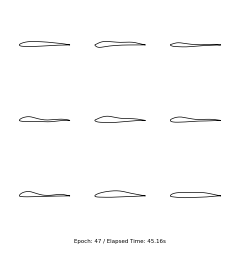

Epoch 49/1000: 100%|██████████| 34/34 [00:00<00:00, 47.39it/s]


Generating and plotting airfoils...


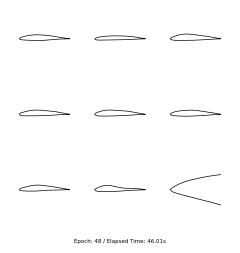

Epoch 50/1000: 100%|██████████| 34/34 [00:00<00:00, 38.28it/s]

Generating and plotting airfoils...


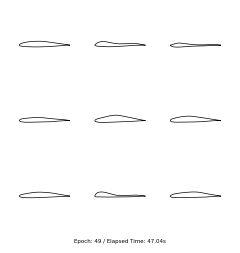

--- Saving model checkpoint for epoch 50 ---


Epoch 51/1000: 100%|██████████| 34/34 [00:00<00:00, 42.62it/s]


Generating and plotting airfoils...


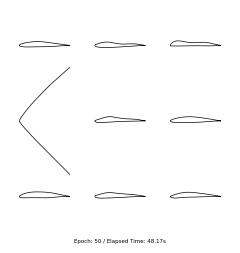

Epoch 52/1000: 100%|██████████| 34/34 [00:00<00:00, 46.12it/s]


Generating and plotting airfoils...


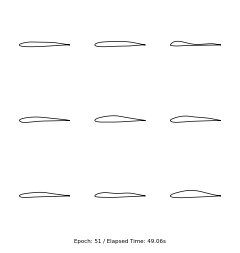

Epoch 53/1000: 100%|██████████| 34/34 [00:00<00:00, 44.74it/s]


Generating and plotting airfoils...


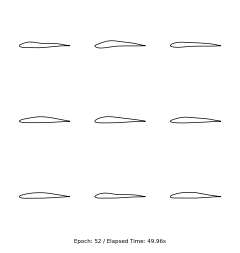

KeyboardInterrupt: 

In [95]:
VERBOSE = 0

# Ensure the models directory exists
models_path = Path(proj_path) / "models" / "cstvae" / time.strftime("%Y%m%d-%H%M%S")
images_path = Path(proj_path) / "images" / "cstvae" / time.strftime("%Y%m%d-%H%M%S")
os.makedirs(models_path, exist_ok=True)
os.makedirs(images_path, exist_ok=True)

# --- The Main Training Loop ---
print("Starting training...")
start_time = time.time()

for epoch in range(EPOCHS):
    
    # Reset metrics at the start of each epoch
    epoch_total_loss = tf.keras.metrics.Mean()
    epoch_reco_loss = tf.keras.metrics.Mean()
    epoch_kl_loss = tf.keras.metrics.Mean()

    # Iterate over each batch in the dataset
    for x_batch in tqdm(train_dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):

        # Run one training step
        total_loss, reco_loss, kl_loss = train_step(x_batch)
        
        # Update the epoch's average loss
        epoch_total_loss.update_state(total_loss)
        epoch_reco_loss.update_state(reco_loss)
        epoch_kl_loss.update_state(kl_loss)

    # --- End of Epoch ---
    elapsed_time = time.time() - start_time
    
    if VERBOSE > 0:
        # Print metrics
        print(f"Epoch {epoch+1}/{EPOCHS}, "
            f"Time: {elapsed_time:.2f}s, "
            f"Total Loss: {epoch_total_loss.result():.4f}, "
            f"Reco Loss: {epoch_reco_loss.result():.4f}, "
            f"KL Loss: {epoch_kl_loss.result():.4f}")
    
    print("Generating and plotting airfoils...")
    generate_and_plot_airfoils(
        vae.decoder, # Note: we pass vae.decoder, not a 'generator'
        epoch=epoch, 
        time=elapsed_time,
        save_path=images_path,
        show=True,
        dpi=300
    )

    # Save model checkpoints every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"--- Saving model checkpoint for epoch {epoch+1} ---")
        
        # vae.save_weights(f"./models/vae_model_epoch_{epoch+1}.weights.h5")
        
        # If you want to save the full model (slower, but saves architecture):
        vae.save(f"{models_path}/model_epoch_{epoch+1}.keras")

print("Training complete.")

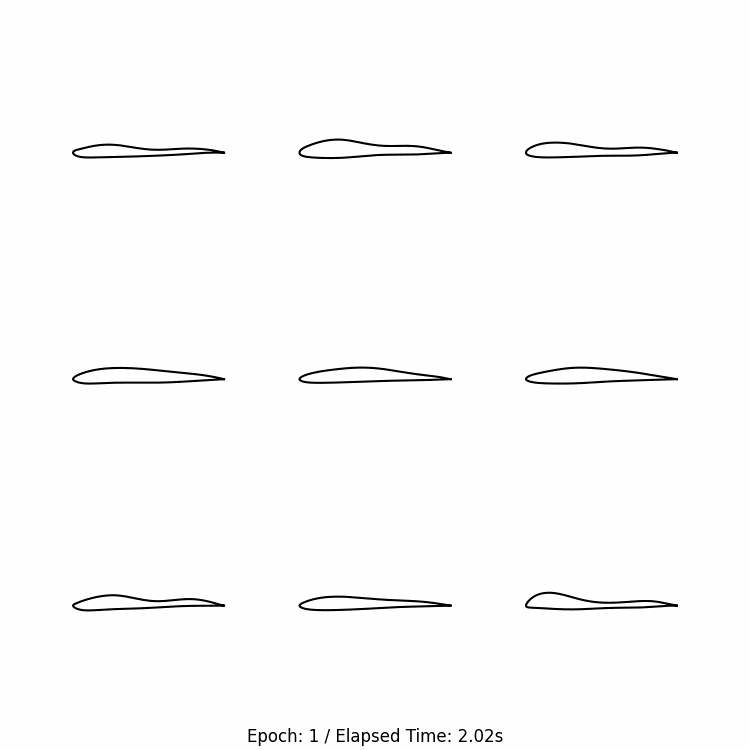

In [96]:
import glob
from PIL import Image
from IPython.display import Image as IPImage # Use an alias to avoid name conflict

# --- Step 1: Find your image files ---
image_folder_path = str(images_path) + "/*.png"

# Get a *sorted* list of file paths.
# Sorting is CRITICAL to make sure your frames are in the right order.
file_paths = sorted(glob.glob(image_folder_path))

# --- Step 2: Load the images ---
# Open the first image, and then all the subsequent images
images = [Image.open(fp) for fp in file_paths]
first_image = images[0]
other_images = images[1:]

# --- Step 3: Save the images as a GIF ---
gif_path = str(images_path) + "/animated.gif"

first_image.save(
    gif_path,
    format="GIF",
    append_images=other_images,  # The list of images to append
    save_all=True,
    duration=100,                # Milliseconds per frame (e.g., 100ms = 10 fps)
    loop=0                       # 0 = loop forever
)

# --- Step 4: Display the GIF in Jupyter ---
# This will embed the GIF directly into your notebook output
IPImage(filename=gif_path)